In [427]:
import pandas as pd

In [428]:
DIR = '/Users/lcq-mac/pycharm_projects/algorithms/tf_practice/tf_learning/deep_recommend/ml-1m/'
users_file = 'users.dat'
movies_file = 'movies.dat'
ratings_file = 'ratings.dat'

In [429]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
df_users = pd.read_table(DIR+users_file, sep='::', header=None, names=users_title, engine='python')
df_users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [430]:
movies_title = ['MovieID', 'Title', 'Genres']
df_movies = pd.read_table(DIR+movies_file, sep='::', header=None, names=movies_title, engine = 'python')
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [431]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
df_ratings = pd.read_table(DIR+ratings_file, sep='::', header=None, names=ratings_title, engine = 'python')
df_ratings.head()
# df_ratings.dtypes

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [432]:
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [433]:
def load_data():
    """
    Load data from file
    """
    # 读取用户数据
    users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
    users = pd.read_table(DIR+users_file, sep='::', header=None, names=users_title, engine='python')
    users = users.filter(regex='UserID|Gender|Age|OccupationID')
    users_origin = users.values
    gender_map = {'M': 1, 'F': 0}
    users['Gender'] = users['Gender'].map(gender_map)
    age_map = {age: x for x, age in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)
    
    # 读取评分数据
    ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
    ratings = pd.read_table(DIR+ratings_file, sep='::', header=None, names=ratings_title, engine = 'python')
#     ratings['irank'] = ratings.groupby('UserID').sorted_values('timestamps', ascending=False)
    ratings = ratings.filter(regex='UserID|MovieID|Rating')
    
    # 读取电影数据
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table(DIR+movies_file, sep='::', header=None, names=movies_title, engine = 'python')
    movies_origin = movies.values
    # 将Title中的年份去除
    pattern = re.compile(r'^(.*)\((\d+)\)$')
    title_rm_year = {title: pattern.match(title).group(1) for i, title in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_rm_year)
    # 将电影类型转数字字典
    gener_type = set()
    for val in movies['Genres'].str.split('|'):
        gener_type.update(val)
    gener_type.add('<PAD>')
    movies_map = {movies_type: i for i, movies_type in enumerate(gener_type)}
    # 将电影类型换成等长数字类型，长度为18
    gener_map = {movie_types:[movies_map[movie_type] for movie_type in movie_types.split('|')] for i, movie_types in enumerate(set(movies['Genres']))}
    for key in gener_map:
        for cnt in range(max(movies_map.values()) - len(gener_map[key])):
            gener_map[key].insert(len(gener_map[key]) + cnt, movies_map['<PAD>'])
    movies['Genres'] = movies['Genres'].map(gener_map) 
    
    # 将电影title转数字字典
    title_set = set()
    for title_word in movies['Title'].str.split():
        title_set.update(title_word)
    title_set.add('<PAD>')
    title_int = {word: i for i, word in enumerate(title_set)}
    # 将电影title转成等长数字列表，长度为15
    title_count = 15
    title_map = {title: [title_int[word] for word in title.split()] for i, title in enumerate(set(movies['Title']))}
    for key in title_map.keys():
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt, title_int['<PAD>'])
    movies['Title'] = movies['Title'].map(title_map)
    
    # 合并三个表
    data = pd.merge(pd.merge(users, ratings, how='inner', on='UserID'), movies, how='inner', on='MovieID')
    
    # 将数据分成X和Y两张表
    target_fields = ['Rating']
    features_pd, target_pd = data.drop(target_fields, axis=1), data[target_fields]
    features = features_pd.values
    target_values = target_pd.values
    
    return title_count, title_set, movies_map, features, target_values, ratings, users, movies, data, movies_origin, users_origin



In [434]:
title_count, title_set, movies_map, features, target_values, ratings, users, movies, data, movies_origin, users_origin = load_data()
import pickle
pickle.dump([title_count, title_set, movies_map, features, target_values, ratings, users, movies, data, movies_origin, users_origin], open('preprocess.p', 'wb'))



In [435]:
users.head()

,UserID,Gender,Age,OccupationID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [436]:
movies.head()

,MovieID,Title,Genres
0,1,"[2202, 1345, 2816, 2816, 2816, 2816, 2816, 281...","[18, 13, 6, 17, 17, 17, 17, 17, 17, 17, 17, 17..."
1,2,"[5041, 2816, 2816, 2816, 2816, 2816, 2816, 281...","[5, 13, 2, 17, 17, 17, 17, 17, 17, 17, 17, 17,..."
2,3,"[1397, 4291, 30, 2816, 2816, 2816, 2816, 2816,...","[6, 12, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17..."
3,4,"[3805, 5183, 3061, 2816, 2816, 2816, 2816, 281...","[6, 9, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,..."
4,5,"[2194, 1040, 3558, 1324, 526, 4704, 2816, 2816...","[6, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17..."


In [437]:
ratings.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [438]:
title_count, title_set, gener_type, features, target_values, ratings, users, movies, data, movies_origin, users_origin = pickle.load(open('preprocess.p', mode='rb'))


In [439]:
data.head()

,UserID,Gender,Age,OccupationID,MovieID,Rating,Title,Genres
0,1,0,0,10,1193,5,"[1630, 3804, 1344, 3558, 5048, 3283, 2816, 281...","[9, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17..."
1,2,1,5,16,1193,5,"[1630, 3804, 1344, 3558, 5048, 3283, 2816, 281...","[9, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17..."
2,12,1,6,12,1193,4,"[1630, 3804, 1344, 3558, 5048, 3283, 2816, 281...","[9, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17..."
3,15,1,6,7,1193,4,"[1630, 3804, 1344, 3558, 5048, 3283, 2816, 281...","[9, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17..."
4,17,1,3,1,1193,5,"[1630, 3804, 1344, 3558, 5048, 3283, 2816, 281...","[9, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17..."


In [440]:
features[0]

array([1, 0, 0, 10, 1193,
       list([1630, 3804, 1344, 3558, 5048, 3283, 2816, 2816, 2816, 2816, 2816, 2816, 2816, 2816, 2816]),
       list([9, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17])],
      dtype=object)

In [441]:
target_values[0]

array([5])

In [442]:
# 嵌入矩阵的维度
embed_dim = 32
# 用户id个数
uid_max = max(features.take(0, 1)) + 1 # 6040
# 性别个数
gender_max = max(features.take(1, 1)) + 1 # 1+1=2
# 年龄个数
age_max = max(features.take(2, 1)) + 1 # 6+1=7
# 职业个数
occu_max = max(features.take(3, 1)) + 1 # 20+1=21

# 电影ID个数
movie_id_max = max(features.take(4, 1)) + 1 # 3952
# 电影类型个数
movie_categories_max = max(movies_map.values()) + 1 # 18+1=19
# 电影名单词个数
movie_title_max = len(title_set)

#对电影类型嵌入向量做 加和操作 或者 mean操作 的标志，
combiner = "sum"

# 电影名长度
sentences_size = title_count # 15
# 文本卷积滑动窗口，分别为2， 3， 4， 5个单词
windows_size = {2, 3, 4, 5}
# 文本卷积核数量
filter_num = 8
# 将电影id转下表的字典，因为电影id所在的行跟其的id不一定完全一致，例如第5行的电影id不一定是5
movieid2idx = {val[0]: i for i, val in enumerate(movies.values)}

In [443]:
##超参数

num_epoch = 5
batch_size = 256
dropout_keep = 0.5
learning_rate = 0.0001
show_every_n_batches = 20

save_dir = "./save"

In [444]:
import tensorflow as tf
data.dtypes

UserID           int64
Gender           int64
Age              int64
OccupationID     int64
MovieID          int64
Rating           int64
Title           object
Genres          object
dtype: object

In [473]:
## 定义输入的占位符
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name='uid')
    user_gender = tf.placeholder(tf.int32, [None, 1], name='user_gender')
    user_age = tf.placeholder(tf.int32, [None, 1], name='user_age')
    user_occu = tf.placeholder(tf.int32, [None, 1], name='user_occu')
    
    movie_id = tf.placeholder(tf.int32, [None, 1], name='movie_id')
    move_categories = tf.placeholder(tf.int32, [None, 18], name='move_categories')
    movie_titles = tf.placeholder(tf.int32, [None, 15], name='movie_titles')
    targets = tf.placeholder(tf.int32, [None, 1], name='targets')
    LearningRate = tf.placeholder(tf.float32, name='LearningRate')
    dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')
    return uid, user_gender, user_age, user_occu, movie_id, move_categories, movie_titles, targets, LearningRate, dropout_keep_prob


In [474]:
## 构建user的嵌入矩阵
def get_user_embedding(uid, user_gender, user_age, user_occu):
    with tf.name_scope('user_embedding'):
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name='uid_embed_matrix')
        uid_emebed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name='uid_embed_layer')
        
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim//2], -1, 1), name='gender_embed_matrix')
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name='gender_embed_layer')
        
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim//2], -1, 1), name='age_embed_matrix')
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name='age_embed_layer')

        occu_embed_matrix = tf.Variable(tf.random_uniform([occu_max, embed_dim//2], -1, 1), name='occu_embed_matrix')
        occu_embed_layer = tf.nn.embedding_lookup(occu_embed_matrix, user_occu, name='occu_embed_layer')
    return uid_emebed_layer, gender_embed_layer, age_embed_layer, occu_embed_layer
     

In [475]:
## 将user的嵌入矩阵一起全连接生成user的特征
def get_user_feature_layer(uid_emebed_layer, gender_embed_layer, age_embed_layer, occu_embed_layer):
    with tf.name_scope('user_fc'):
        # 第一层全连接
        uid_fc_layer = tf.layers.dense(uid_emebed_layer, embed_dim, name='uid_fc_layer', activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name='gender_fc_layer', activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name='age_fc_layer', activation=tf.nn.relu)
        occu_fc_layer = tf.layers.dense(occu_embed_layer, embed_dim, name='occu_fc_layer', activation=tf.nn.relu)
        
        # 第二层全连接
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, occu_fc_layer], 2)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)
        
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

        

In [476]:

def get_movie_id_embed_layer(movie_id):
    with tf.name_scope('movie_embedding'):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name='movie_id_embed_matrix')
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name='movie_id_embed_layer')
    return movie_id_embed_layer
        
        

In [477]:
# 对电影类型的多个向量做加和
def get_movie_categories_layer(movie_categories):
    with tf.name_scope('movie_categories_layers'):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name='movie_categories_embed_matrix')
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name='movie_categories_embed_layer')
        if combiner == 'sum':
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
            
    return movie_categories_embed_layer

    

In [478]:
# Movie title 的卷积神经网络实现
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in windows_size:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)

    #Dropout层
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(windows_size) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer



In [479]:
# 将Movie的各个层一起做全连接
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        #第一层全连接
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        #第二层全连接
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

In [480]:
# 构建计算图
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_occu, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer, gender_embed_layer, age_embed_layer, occu_embed_layer = get_user_embedding(uid, user_gender, user_age, user_occu)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, occu_embed_layer)
    #获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    #获取电影类型的嵌入向量
    movie_categories_embed_layer = get_movie_categories_layer(movie_categories)
    #获取电影名的特征向量
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    #得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                dropout_layer)
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    with tf.name_scope("inference"):
        #将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
#         inference_layer = tf.concat([user_combine_layer_flat, movie_combine_layer_flat], 1)  #(?, 200)
#         inference = tf.layers.dense(inference_layer, 1,
#                                     kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), 
#                                     kernel_regularizer=tf.nn.l2_loss, name="inference")
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
#        inference = tf.matmul(user_combine_layer_flat, tf.transpose(movie_combine_layer_flat))
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    # 优化损失 
#     train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)

In [481]:
inference

<tf.Tensor 'inference/ExpandDims:0' shape=(?, 1) dtype=float32>

In [482]:
# 取得batch
def get_batch(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start+batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [491]:
# 训练网络
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import os

losses = {"train": [], "test": []}

with tf.Session(graph=train_graph) as sess:
        #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
    
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
    
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)
    
    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    for epoch_i in range(num_epoch):
        # 将数据集分成训练集和测试集，随机种子不固定
#         print("features type:", type(features))
#         print("target_values type:", type(target_values))
#         print("features shape:", features.shape)
#         print("target_values shape:", target_values.shape)
#         print("features len:", len(features))
#         print("target_values len:", len(target_values))
#         print("features :", features[1])
#         print("target_values :", target_values[1])
        train_X, test_X, train_y, test_y = train_test_split(features, target_values, test_size=0.2, random_state=0)
#         print("train_X len:", len(train_X))
#         print("test_X len:", len(test_X))
        
        train_batch = get_batch(train_X, train_y, batch_size)
        test_batch = get_batch(test_X, test_y, batch_size)
        
        # 训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
#             print("batch_i:", batch_i)
            x, y = next(train_batch)
#             print("x:", x)
#             print("y:", y)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6, 1)[i]
            
            title = np.zeros([batch_size, 15])
            for i in range(batch_size):
                title[i] = x.take(5, 1)[i]
            
            feed = {
                uid: np.reshape(x.take(0, 1), [batch_size, 1]),
                user_gender: np.reshape(x.take(1, 1), [batch_size, 1]),
                user_age: np.reshape(x.take(2, 1), [batch_size, 1]),
                user_occu: np.reshape(x.take(3, 1), [batch_size, 1]),
                movie_id: np.reshape(x.take(4, 1), [batch_size, 1]),
                movie_titles: title,
                movie_categories: categories,
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate
            }
            
            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
#             print("Run completed!!!!!!!")
            #保存训练损失
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  
            
            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(train_X)//batch_size) + batch_i) % show_every_n_batches == 0:
                print("{}: Epoch {:>3} Batch {:>4}/{} test_loss={:.3f}".format(
                    time_str,
                    epoch_i,
                    batch_i,
                    len(train_X)//batch_size,
                    train_loss
                    ))

        # 测试的迭代
        for batch_i in range(len(test_X) // batch_size):
#             print("batch_i:", batch_i)
            x, y = next(test_batch)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6, 1)[i]
            
            title = np.zeros([batch_size, 15])
            for i in range(batch_size):
                title[i] = x.take(5, 1)[i]
            
            feed = {
                uid: np.reshape(x.take(0, 1), [batch_size, 1]),
                user_gender: np.reshape(x.take(1, 1), [batch_size, 1]),
                user_age: np.reshape(x.take(2, 1), [batch_size, 1]),
                user_occu: np.reshape(x.take(3, 1), [batch_size, 1]),
                movie_id: np.reshape(x.take(4, 1), [batch_size, 1]),
                movie_titles: title,
                movie_categories: categories,
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate
            }
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost
            
            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  
            
            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X)//batch_size) + batch_i) % show_every_n_batches == 0:
                print("{}: Epoch {:>3} Batch {:>4}/{} test_loss={:.3f}".format(
                    time_str,
                    epoch_i,
                    batch_i,
                    len(test_X)//batch_size,
                    test_loss
                    ))
            
    # Save model
    saver.save(sess, save_dir)
    print("Model trained and saved!")
    
    

Writing to /Users/lcq-mac/pycharm_projects/algorithms/tf_practice/tf_learning/deep_recommend/runs/1564832308

2019-08-03T19:38:33.490865: Epoch   0 Batch    0/3125 test_loss=22.963
2019-08-03T19:38:34.037289: Epoch   0 Batch   20/3125 test_loss=4.925
2019-08-03T19:38:34.632021: Epoch   0 Batch   40/3125 test_loss=3.191
2019-08-03T19:38:35.198940: Epoch   0 Batch   60/3125 test_loss=1.776
2019-08-03T19:38:35.716891: Epoch   0 Batch   80/3125 test_loss=1.730
2019-08-03T19:38:36.242255: Epoch   0 Batch  100/3125 test_loss=1.837
2019-08-03T19:38:36.797905: Epoch   0 Batch  120/3125 test_loss=1.690
2019-08-03T19:38:37.341117: Epoch   0 Batch  140/3125 test_loss=1.623
2019-08-03T19:38:37.885182: Epoch   0 Batch  160/3125 test_loss=1.296
2019-08-03T19:38:38.435456: Epoch   0 Batch  180/3125 test_loss=1.403
2019-08-03T19:38:38.951427: Epoch   0 Batch  200/3125 test_loss=1.635
2019-08-03T19:38:39.495481: Epoch   0 Batch  220/3125 test_loss=1.408
2019-08-03T19:38:40.022288: Epoch   0 Batch  240/

2019-08-03T19:39:36.761632: Epoch   0 Batch 2320/3125 test_loss=1.267
2019-08-03T19:39:37.294527: Epoch   0 Batch 2340/3125 test_loss=1.127
2019-08-03T19:39:37.898228: Epoch   0 Batch 2360/3125 test_loss=1.128
2019-08-03T19:39:38.470777: Epoch   0 Batch 2380/3125 test_loss=1.082
2019-08-03T19:39:39.053240: Epoch   0 Batch 2400/3125 test_loss=1.259
2019-08-03T19:39:39.582329: Epoch   0 Batch 2420/3125 test_loss=1.034
2019-08-03T19:39:40.127409: Epoch   0 Batch 2440/3125 test_loss=1.301
2019-08-03T19:39:40.657213: Epoch   0 Batch 2460/3125 test_loss=1.061
2019-08-03T19:39:41.202954: Epoch   0 Batch 2480/3125 test_loss=1.185
2019-08-03T19:39:41.717478: Epoch   0 Batch 2500/3125 test_loss=1.128
2019-08-03T19:39:42.251782: Epoch   0 Batch 2520/3125 test_loss=1.007
2019-08-03T19:39:42.782475: Epoch   0 Batch 2540/3125 test_loss=1.112
2019-08-03T19:39:43.323592: Epoch   0 Batch 2560/3125 test_loss=0.910
2019-08-03T19:39:43.904534: Epoch   0 Batch 2580/3125 test_loss=1.049
2019-08-03T19:39:44.

2019-08-03T19:40:25.114944: Epoch   1 Batch  755/3125 test_loss=1.163
2019-08-03T19:40:25.642663: Epoch   1 Batch  775/3125 test_loss=0.984
2019-08-03T19:40:26.230508: Epoch   1 Batch  795/3125 test_loss=1.066
2019-08-03T19:40:26.775893: Epoch   1 Batch  815/3125 test_loss=1.055
2019-08-03T19:40:27.276096: Epoch   1 Batch  835/3125 test_loss=1.034
2019-08-03T19:40:27.818171: Epoch   1 Batch  855/3125 test_loss=1.274
2019-08-03T19:40:28.323397: Epoch   1 Batch  875/3125 test_loss=1.118
2019-08-03T19:40:28.846909: Epoch   1 Batch  895/3125 test_loss=1.032
2019-08-03T19:40:29.358177: Epoch   1 Batch  915/3125 test_loss=1.076
2019-08-03T19:40:29.877277: Epoch   1 Batch  935/3125 test_loss=1.106
2019-08-03T19:40:30.383232: Epoch   1 Batch  955/3125 test_loss=1.144
2019-08-03T19:40:30.912199: Epoch   1 Batch  975/3125 test_loss=1.145
2019-08-03T19:40:31.412541: Epoch   1 Batch  995/3125 test_loss=0.818
2019-08-03T19:40:31.952092: Epoch   1 Batch 1015/3125 test_loss=1.102
2019-08-03T19:40:32.

2019-08-03T19:41:27.081320: Epoch   1 Batch 3115/3125 test_loss=0.856
2019-08-03T19:41:27.461933: Epoch   1 Batch   19/781 test_loss=1.036
2019-08-03T19:41:27.618868: Epoch   1 Batch   39/781 test_loss=0.802
2019-08-03T19:41:27.771475: Epoch   1 Batch   59/781 test_loss=0.882
2019-08-03T19:41:27.928683: Epoch   1 Batch   79/781 test_loss=1.022
2019-08-03T19:41:28.107106: Epoch   1 Batch   99/781 test_loss=0.967
2019-08-03T19:41:28.252660: Epoch   1 Batch  119/781 test_loss=0.940
2019-08-03T19:41:28.396599: Epoch   1 Batch  139/781 test_loss=1.000
2019-08-03T19:41:28.537714: Epoch   1 Batch  159/781 test_loss=1.006
2019-08-03T19:41:28.695995: Epoch   1 Batch  179/781 test_loss=0.876
2019-08-03T19:41:28.842689: Epoch   1 Batch  199/781 test_loss=0.936
2019-08-03T19:41:28.989115: Epoch   1 Batch  219/781 test_loss=1.062
2019-08-03T19:41:29.132105: Epoch   1 Batch  239/781 test_loss=1.195
2019-08-03T19:41:29.278956: Epoch   1 Batch  259/781 test_loss=0.981
2019-08-03T19:41:29.422678: Epoch

2019-08-03T19:42:15.335345: Epoch   2 Batch 1570/3125 test_loss=0.944
2019-08-03T19:42:15.854060: Epoch   2 Batch 1590/3125 test_loss=0.938
2019-08-03T19:42:16.412999: Epoch   2 Batch 1610/3125 test_loss=0.940
2019-08-03T19:42:16.945627: Epoch   2 Batch 1630/3125 test_loss=1.042
2019-08-03T19:42:17.458104: Epoch   2 Batch 1650/3125 test_loss=0.794
2019-08-03T19:42:18.008263: Epoch   2 Batch 1670/3125 test_loss=0.785
2019-08-03T19:42:18.510749: Epoch   2 Batch 1690/3125 test_loss=0.923
2019-08-03T19:42:19.073395: Epoch   2 Batch 1710/3125 test_loss=0.959
2019-08-03T19:42:19.581278: Epoch   2 Batch 1730/3125 test_loss=0.978
2019-08-03T19:42:20.115468: Epoch   2 Batch 1750/3125 test_loss=0.823
2019-08-03T19:42:20.624542: Epoch   2 Batch 1770/3125 test_loss=1.060
2019-08-03T19:42:21.160428: Epoch   2 Batch 1790/3125 test_loss=0.981
2019-08-03T19:42:21.676248: Epoch   2 Batch 1810/3125 test_loss=0.985
2019-08-03T19:42:22.185141: Epoch   2 Batch 1830/3125 test_loss=1.018
2019-08-03T19:42:22.

2019-08-03T19:43:03.620602: Epoch   3 Batch   25/3125 test_loss=0.935
2019-08-03T19:43:04.131997: Epoch   3 Batch   45/3125 test_loss=0.803
2019-08-03T19:43:04.673639: Epoch   3 Batch   65/3125 test_loss=0.939
2019-08-03T19:43:05.254790: Epoch   3 Batch   85/3125 test_loss=0.816
2019-08-03T19:43:05.811920: Epoch   3 Batch  105/3125 test_loss=0.736
2019-08-03T19:43:06.310813: Epoch   3 Batch  125/3125 test_loss=0.874
2019-08-03T19:43:06.847118: Epoch   3 Batch  145/3125 test_loss=0.921
2019-08-03T19:43:07.358104: Epoch   3 Batch  165/3125 test_loss=0.919
2019-08-03T19:43:07.933557: Epoch   3 Batch  185/3125 test_loss=0.762
2019-08-03T19:43:08.436600: Epoch   3 Batch  205/3125 test_loss=0.792
2019-08-03T19:43:08.967768: Epoch   3 Batch  225/3125 test_loss=0.822
2019-08-03T19:43:09.476977: Epoch   3 Batch  245/3125 test_loss=1.040
2019-08-03T19:43:10.024097: Epoch   3 Batch  265/3125 test_loss=0.858
2019-08-03T19:43:10.540894: Epoch   3 Batch  285/3125 test_loss=0.896
2019-08-03T19:43:11.

2019-08-03T19:44:06.200068: Epoch   3 Batch 2385/3125 test_loss=0.901
2019-08-03T19:44:06.696132: Epoch   3 Batch 2405/3125 test_loss=0.910
2019-08-03T19:44:07.200399: Epoch   3 Batch 2425/3125 test_loss=0.812
2019-08-03T19:44:07.708800: Epoch   3 Batch 2445/3125 test_loss=0.919
2019-08-03T19:44:08.226177: Epoch   3 Batch 2465/3125 test_loss=0.769
2019-08-03T19:44:08.743301: Epoch   3 Batch 2485/3125 test_loss=0.853
2019-08-03T19:44:09.263248: Epoch   3 Batch 2505/3125 test_loss=0.868
2019-08-03T19:44:09.791404: Epoch   3 Batch 2525/3125 test_loss=0.818
2019-08-03T19:44:10.303532: Epoch   3 Batch 2545/3125 test_loss=0.946
2019-08-03T19:44:10.830268: Epoch   3 Batch 2565/3125 test_loss=0.839
2019-08-03T19:44:11.358869: Epoch   3 Batch 2585/3125 test_loss=0.775
2019-08-03T19:44:11.944039: Epoch   3 Batch 2605/3125 test_loss=0.839
2019-08-03T19:44:12.434282: Epoch   3 Batch 2625/3125 test_loss=1.002
2019-08-03T19:44:12.954888: Epoch   3 Batch 2645/3125 test_loss=0.892
2019-08-03T19:44:13.

2019-08-03T19:44:55.360440: Epoch   4 Batch  840/3125 test_loss=0.802
2019-08-03T19:44:55.923832: Epoch   4 Batch  860/3125 test_loss=0.845
2019-08-03T19:44:56.489054: Epoch   4 Batch  880/3125 test_loss=0.785
2019-08-03T19:44:57.049984: Epoch   4 Batch  900/3125 test_loss=0.873
2019-08-03T19:44:57.617958: Epoch   4 Batch  920/3125 test_loss=0.929
2019-08-03T19:44:58.191220: Epoch   4 Batch  940/3125 test_loss=0.836
2019-08-03T19:44:58.748678: Epoch   4 Batch  960/3125 test_loss=0.893
2019-08-03T19:44:59.289572: Epoch   4 Batch  980/3125 test_loss=0.955
2019-08-03T19:44:59.843940: Epoch   4 Batch 1000/3125 test_loss=0.964
2019-08-03T19:45:00.452350: Epoch   4 Batch 1020/3125 test_loss=0.925
2019-08-03T19:45:01.014149: Epoch   4 Batch 1040/3125 test_loss=0.790
2019-08-03T19:45:01.608087: Epoch   4 Batch 1060/3125 test_loss=0.956
2019-08-03T19:45:02.177421: Epoch   4 Batch 1080/3125 test_loss=0.888
2019-08-03T19:45:02.747701: Epoch   4 Batch 1100/3125 test_loss=0.818
2019-08-03T19:45:03.

2019-08-03T19:46:01.920849: Epoch   4 Batch   96/781 test_loss=1.016
2019-08-03T19:46:02.086231: Epoch   4 Batch  116/781 test_loss=0.892
2019-08-03T19:46:02.254629: Epoch   4 Batch  136/781 test_loss=0.835
2019-08-03T19:46:02.413852: Epoch   4 Batch  156/781 test_loss=0.920
2019-08-03T19:46:02.571824: Epoch   4 Batch  176/781 test_loss=0.848
2019-08-03T19:46:02.731299: Epoch   4 Batch  196/781 test_loss=0.807
2019-08-03T19:46:02.895333: Epoch   4 Batch  216/781 test_loss=0.965
2019-08-03T19:46:03.045463: Epoch   4 Batch  236/781 test_loss=0.825
2019-08-03T19:46:03.201781: Epoch   4 Batch  256/781 test_loss=0.836
2019-08-03T19:46:03.349663: Epoch   4 Batch  276/781 test_loss=1.068
2019-08-03T19:46:03.496601: Epoch   4 Batch  296/781 test_loss=0.860
2019-08-03T19:46:03.645104: Epoch   4 Batch  316/781 test_loss=0.829
2019-08-03T19:46:03.806871: Epoch   4 Batch  336/781 test_loss=0.810
2019-08-03T19:46:03.966297: Epoch   4 Batch  356/781 test_loss=0.875
2019-08-03T19:46:04.115647: Epoch 

In [498]:
# 辅助函数
def save_params(params):
    """
    save parameters to file
    """
    pickle.dump(params, open("params.p", 'wb'))
    
def load_params():
    """
    load parameters from file
    """
    return pickle.load(open("params.p", 'rb'))


In [500]:
save_params(save_dir)
load_params()

'./save'

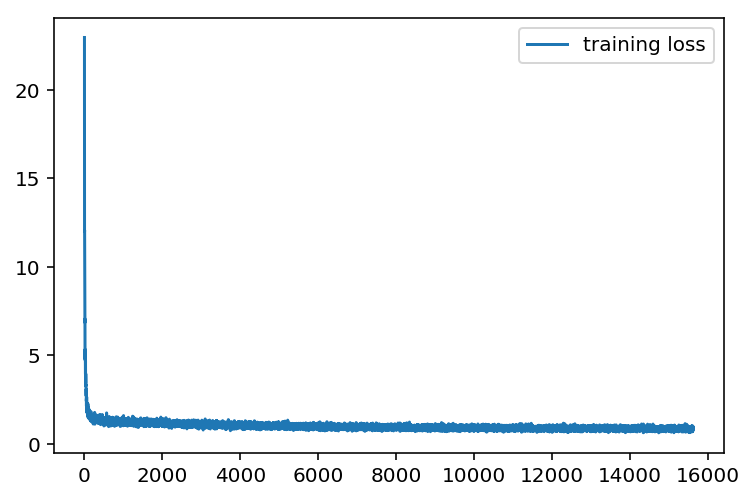

In [506]:
plt.plot(losses['train'], label="training loss")
plt.legend()

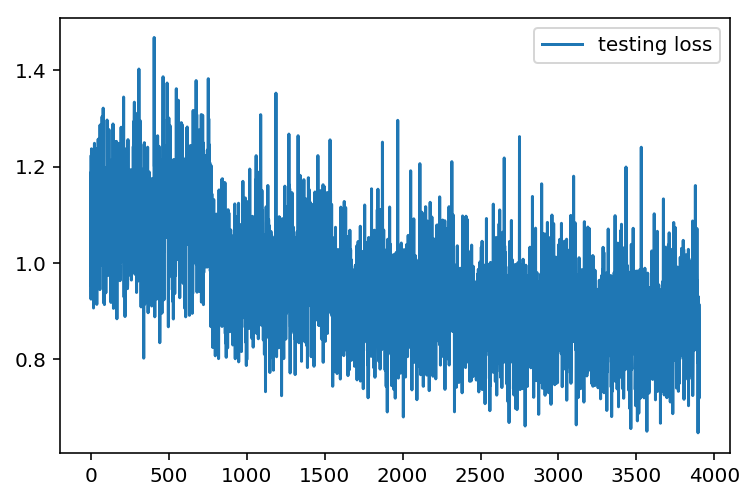

In [507]:
plt.plot(losses['test'], label="testing loss")
plt.legend()

In [ ]:
## 获取tensor

